# Natural Language Processing with Deep Learning (7 points)

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model ca access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

In [2]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)['FullDescription']

137458    Staff Nurse  Registered Mental Nurse / RMN / R...
157368    This role will be working for an international...
225054    Our client is an award winning hotel located i...
Name: FullDescription, dtype: object

In [3]:
data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
22989,67441962,Car Park Attendant,Our Client requires a Car Park Attendant to st...,Liverpool,Liverpool,full_time,NaN,Recruit Right,Customer Services Jobs,6.19 - 6.19 per hour,11884,Jobcentre Plus,9.383033
233167,72480497,Field Service Engineer Food Manufacturing,"Are you a Maintenance Engineer, experienced in...","Northamptonshire,Bedfordshire,Cambridgeshire,N...",UK,NaN,permanent,Mark Burnard,Engineering Jobs,31k - 35k per year,33000,jobsite.co.uk,10.404293
175903,71451049,Senior Accountant,Senior Accountant / Auditor Two Senior Account...,Stoke on Trent,Stoke-On-Trent,NaN,permanent,NaN,Accounting & Finance Jobs,20000- 27000,23500,hays.co.uk,10.064798


### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [4]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [5]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [6]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [7]:
data['Title']

0                               engineering systems analyst
1                                   stress engineer glasgow
2                          modelling and simulation analyst
3         engineering systems analyst / mathematical mod...
4               pioneer , miser engineering systems analyst
5                engineering systems analyst water industry
6                 senior subsea pipeline integrity engineer
7         recruitment consultant industrial / commercial...
8         recruitment consultant construction / technica...
9                                    subsea cables engineer
10                   trainee mortgage advisor east midlands
11                        project engineer , pharmaceutical
12                      principal composite stress engineer
13                 senior fatigue damage tolerance engineer
14        chef de partie award winning restaurant excell...
15                                         quality engineer
16                              principa

In [8]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in "Title" and "FullDescription"
from tqdm import tqdm

for i in tqdm(range(len(data))):
    title_tokens = data.loc[[i]]['Title'].values[0].split()
    token_counts.update(title_tokens)
    descr_tokens = data.loc[[i]]['FullDescription'].values[0].split()
    token_counts.update(descr_tokens)

100%|█████████████████████████████████████████████████████████████████████████| 244768/244768 [05:01<00:00, 831.60it/s]


In [9]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


Text(0.5, 0, 'Counts')

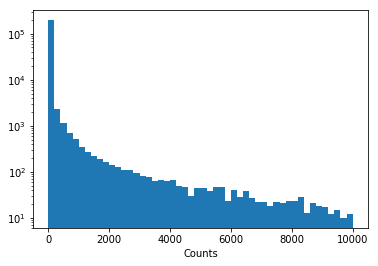

In [10]:
# Let's see how many words are there for each count

_ = plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [11]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [token for (token, count) in token_counts.items() if count >= 10]

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [12]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [13]:
token_to_id = {token: index for (index, token) in enumerate(tokens)}

In [14]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [15]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [16]:
#### print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[    2     3     4     1     1]
 [  550  2380     1     1     1]
 [  320 10714   392   307    32]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [17]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
        sparse=False)

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [18]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [19]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)
    
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

In [20]:
generate_batch(data_train, 3, max_len=10)

{'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'FullDescription': array([[  31,   32,  328, 8453, 1020,    3,   16, 3106,  267, 1226],
        [7770,    0,   12,   18,   19,  183,  420,    0,  130,    0],
        [ 156,  130,  906,  422, 2045,  130, 1402,   75,  272, 5321]]),
 'Log1pSalary': array([10.71444 ,  9.431963, 10.491302], dtype=float32),
 'Title': array([[   31,    32,   328,   392,   393,     2,   101],
        [15992,     1,     1,     1,     1,     1,     1],
        [  906,   422,  1402,    75,     1,     1,     1]])}

### Finally, let's talk deep learning

Out model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [21]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [22]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = self.pool1(h)
        h = nn.ReLU()(h)
        h = self.dense(h)
        
        return h

In [23]:
title_encoder = TitleEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

Seems fine


__Task 2.1__ Create description encoder

In [24]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()        
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        h = self.emb(text_ix)
        h = torch.transpose(h, 1, 2)
        h = self.conv1(h)
        h = self.pool1(h)
        h = nn.ReLU()(h)
        h = self.dense(h)
        return h

In [25]:
desc_encoder = DescriptionEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['FullDescription']))
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

Seems fine too


__Task 2.2__ Build one network ~~to rule them all~~

In [26]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = DescriptionEncoder(out_size=64)
        
        # define layers for categorical features. A few dense layers would do.
        self.cat_encoder = nn.Sequential(
            nn.Linear(n_cat_features, 256),
            nn.ReLU(),
            nn.Linear(256, 64)
        )
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.out_layers = nn.Sequential(
            nn.Linear(192, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.cat_encoder(cat_features)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        out = self.out_layers(joint_h)
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return out[:, 0]

In [27]:
model = FullNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [28]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
reference = torch.tensor(batch[target_column], dtype=torch.float32)

prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [29]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference) - torch.exp(prediction)).mean()

In [30]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it!

In [31]:
from tqdm import tnrange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [32]:
num_epochs = 100
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [33]:
for epoch_i in range(num_epochs):
    
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
        reference = torch.tensor(batch[target_column], dtype=torch.float32)

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.numpy()
        train_mae += compute_mae(reference, prediction).data.numpy()
        train_batches += 1
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
        reference = torch.tensor(batch[target_column], dtype=torch.float32)
        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.numpy()
        val_mae += compute_mae(reference, prediction).data.numpy()
        val_batches += 1
        
    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

Training:


A Jupyter Widget


	Loss:	10.92411
	MAE:	83792.30479



Validation:


A Jupyter Widget


	Loss:	0.56162
	MAE:	19575.01747



Training:


A Jupyter Widget


	Loss:	0.45527
	MAE:	17582.85221



Validation:


A Jupyter Widget


	Loss:	0.38956
	MAE:	16798.62333



Training:


A Jupyter Widget


	Loss:	0.35637
	MAE:	15468.93521



Validation:


A Jupyter Widget


	Loss:	0.31223
	MAE:	13968.95580



Training:


A Jupyter Widget


	Loss:	0.28720
	MAE:	13614.12872



Validation:


A Jupyter Widget


	Loss:	0.27749
	MAE:	12753.73839



Training:


A Jupyter Widget


	Loss:	0.26147
	MAE:	12867.24640



Validation:


A Jupyter Widget


	Loss:	0.26245
	MAE:	12289.61476



Training:


A Jupyter Widget


	Loss:	0.25824
	MAE:	12857.56745



Validation:


A Jupyter Widget


	Loss:	0.23679
	MAE:	11699.86771



Training:


A Jupyter Widget


	Loss:	0.22907
	MAE:	12168.86751



Validation:


A Jupyter Widget


	Loss:	0.25784
	MAE:	15019.86033



Training:


A Jupyter Widget


	Loss:	0.21514
	MAE:	11768.54860



Validation:


A Jupyter Widget


	Loss:	0.19688
	MAE:	11422.91269



Training:


A Jupyter Widget


	Loss:	0.20849
	MAE:	11464.38806



Validation:


A Jupyter Widget


	Loss:	0.20615
	MAE:	12630.19946



Training:


A Jupyter Widget


	Loss:	0.21083
	MAE:	12010.53401



Validation:


A Jupyter Widget


	Loss:	0.23624
	MAE:	14363.88203



Training:


A Jupyter Widget


	Loss:	0.18775
	MAE:	10853.54232



Validation:


A Jupyter Widget


	Loss:	0.18702
	MAE:	10428.06043



Training:


A Jupyter Widget


	Loss:	0.17926
	MAE:	11054.09083



Validation:


A Jupyter Widget


	Loss:	0.16627
	MAE:	10288.24597



Training:


A Jupyter Widget


	Loss:	0.16538
	MAE:	10380.83806



Validation:


A Jupyter Widget


	Loss:	0.16686
	MAE:	10014.92919



Training:


A Jupyter Widget


	Loss:	0.16332
	MAE:	10669.88619



Validation:


A Jupyter Widget


	Loss:	0.15567
	MAE:	9944.21524



Training:


A Jupyter Widget


	Loss:	0.15889
	MAE:	10094.08950



Validation:


A Jupyter Widget


	Loss:	0.16182
	MAE:	9856.78757



Training:


A Jupyter Widget


	Loss:	0.16977
	MAE:	10632.88897



Validation:


A Jupyter Widget


	Loss:	0.16943
	MAE:	11468.77161



Training:


A Jupyter Widget


	Loss:	0.14406
	MAE:	9774.78976



Validation:


A Jupyter Widget


	Loss:	0.15747
	MAE:	10909.35605



Training:


A Jupyter Widget


	Loss:	0.14642
	MAE:	9678.13228



Validation:


A Jupyter Widget


	Loss:	0.14575
	MAE:	10103.00836



Training:


A Jupyter Widget


	Loss:	0.15039
	MAE:	9959.22735



Validation:


A Jupyter Widget


	Loss:	0.16714
	MAE:	9861.03007



Training:


A Jupyter Widget


	Loss:	0.14386
	MAE:	9646.04441



Validation:


A Jupyter Widget


	Loss:	0.13283
	MAE:	9528.97102



Training:


A Jupyter Widget


	Loss:	0.14022
	MAE:	9729.80182



Validation:


A Jupyter Widget


	Loss:	0.13188
	MAE:	9346.57157



Training:


A Jupyter Widget


	Loss:	0.14286
	MAE:	9663.52842



Validation:


A Jupyter Widget


	Loss:	0.12856
	MAE:	9275.14273



Training:


A Jupyter Widget


	Loss:	0.15699
	MAE:	10520.57104



Validation:


A Jupyter Widget


	Loss:	0.14181
	MAE:	9337.68805



Training:


A Jupyter Widget


	Loss:	0.13950
	MAE:	9617.05858



Validation:


A Jupyter Widget


	Loss:	0.12746
	MAE:	9397.09941



Training:


A Jupyter Widget


	Loss:	0.14690
	MAE:	9880.17367



Validation:


A Jupyter Widget


	Loss:	0.12305
	MAE:	8879.49060



Training:


A Jupyter Widget


	Loss:	0.12669
	MAE:	9216.02381



Validation:


A Jupyter Widget


	Loss:	0.13131
	MAE:	9036.54184



Training:


A Jupyter Widget


	Loss:	0.11515
	MAE:	8803.93208



Validation:


A Jupyter Widget


	Loss:	0.11764
	MAE:	8830.21311



Training:


A Jupyter Widget


	Loss:	0.15525
	MAE:	10430.86485



Validation:


A Jupyter Widget


	Loss:	0.16437
	MAE:	9920.61051



Training:


A Jupyter Widget


	Loss:	0.14374
	MAE:	10280.60314



Validation:


A Jupyter Widget


	Loss:	0.11869
	MAE:	8659.85901



Training:


A Jupyter Widget


	Loss:	0.12751
	MAE:	9391.82905



Validation:


A Jupyter Widget


	Loss:	0.13706
	MAE:	10236.41803



Training:


A Jupyter Widget


	Loss:	0.12135
	MAE:	8844.67552



Validation:


A Jupyter Widget


	Loss:	0.11467
	MAE:	8864.19049



Training:


A Jupyter Widget


	Loss:	0.11239
	MAE:	8973.27014



Validation:


A Jupyter Widget


	Loss:	0.12499
	MAE:	9661.33498



Training:


A Jupyter Widget


	Loss:	0.14355
	MAE:	9760.26279



Validation:


A Jupyter Widget


	Loss:	0.12109
	MAE:	9247.31084



Training:


A Jupyter Widget


	Loss:	0.12840
	MAE:	9456.16130



Validation:


A Jupyter Widget


	Loss:	0.11827
	MAE:	9141.22016



Training:


A Jupyter Widget


	Loss:	0.11944
	MAE:	9073.24559



Validation:


A Jupyter Widget


	Loss:	0.12295
	MAE:	9559.42164



Training:


A Jupyter Widget


	Loss:	0.11144
	MAE:	8475.67231



Validation:


A Jupyter Widget


	Loss:	0.12478
	MAE:	8807.34936



Training:


A Jupyter Widget


	Loss:	0.11187
	MAE:	8590.04171



Validation:


A Jupyter Widget


	Loss:	0.10934
	MAE:	8728.36133



Training:


A Jupyter Widget


	Loss:	0.12332
	MAE:	9112.07840



Validation:


A Jupyter Widget


	Loss:	0.11445
	MAE:	8945.84642



Training:


A Jupyter Widget


	Loss:	0.10370
	MAE:	8484.35171



Validation:


A Jupyter Widget


	Loss:	0.10463
	MAE:	8402.70565



Training:


A Jupyter Widget


	Loss:	0.11539
	MAE:	8899.59528



Validation:


A Jupyter Widget


	Loss:	0.12364
	MAE:	9833.83747



Training:


A Jupyter Widget


	Loss:	0.10749
	MAE:	8389.99607



Validation:


A Jupyter Widget


	Loss:	0.10400
	MAE:	8284.59899



Training:


A Jupyter Widget


	Loss:	0.10525
	MAE:	8491.86324



Validation:


A Jupyter Widget


	Loss:	0.11195
	MAE:	8899.34052



Training:


A Jupyter Widget


	Loss:	0.10377
	MAE:	8151.58870



Validation:


A Jupyter Widget


	Loss:	0.10084
	MAE:	8148.74309



Training:


A Jupyter Widget


	Loss:	0.10440
	MAE:	8436.10218



Validation:


A Jupyter Widget


	Loss:	0.10530
	MAE:	8595.29184



Training:


A Jupyter Widget


	Loss:	0.11040
	MAE:	8679.34446



Validation:


A Jupyter Widget


	Loss:	0.13602
	MAE:	10304.29076



Training:


A Jupyter Widget


	Loss:	0.11781
	MAE:	8991.17251



Validation:


A Jupyter Widget


	Loss:	0.11659
	MAE:	9292.91296



Training:


A Jupyter Widget


	Loss:	0.11455
	MAE:	8824.89041



Validation:


A Jupyter Widget


	Loss:	0.13826
	MAE:	9301.73833



Training:


A Jupyter Widget


	Loss:	0.11397
	MAE:	8823.28582



Validation:


A Jupyter Widget


	Loss:	0.10306
	MAE:	8457.37921



Training:


A Jupyter Widget


	Loss:	0.10533
	MAE:	8348.96593



Validation:


A Jupyter Widget


	Loss:	0.12975
	MAE:	10272.73088



Training:


A Jupyter Widget


	Loss:	0.10702
	MAE:	8365.90531



Validation:


A Jupyter Widget


	Loss:	0.10097
	MAE:	8017.01590



Training:


A Jupyter Widget


	Loss:	0.11285
	MAE:	8928.71280



Validation:


A Jupyter Widget


	Loss:	0.11471
	MAE:	9281.91550



Training:


A Jupyter Widget


	Loss:	0.10288
	MAE:	8748.62237



Validation:


A Jupyter Widget


	Loss:	0.13083
	MAE:	8909.27527



Training:


A Jupyter Widget


	Loss:	0.10786
	MAE:	8733.33291



Validation:


A Jupyter Widget


	Loss:	0.11374
	MAE:	8514.11181



Training:


A Jupyter Widget


	Loss:	0.10810
	MAE:	8585.09967



Validation:


A Jupyter Widget


	Loss:	0.12458
	MAE:	9816.61647



Training:


A Jupyter Widget


	Loss:	0.11048
	MAE:	8708.68886



Validation:


A Jupyter Widget


	Loss:	0.11677
	MAE:	9540.10831



Training:


A Jupyter Widget


	Loss:	0.09856
	MAE:	8072.81511



Validation:


A Jupyter Widget


	Loss:	0.11872
	MAE:	8703.46524



Training:


A Jupyter Widget


	Loss:	0.09685
	MAE:	8175.59022



Validation:


A Jupyter Widget


	Loss:	0.10898
	MAE:	9090.44585



Training:


A Jupyter Widget


	Loss:	0.09966
	MAE:	8146.67797



Validation:


A Jupyter Widget


	Loss:	0.14366
	MAE:	11027.61157



Training:


A Jupyter Widget


	Loss:	0.09454
	MAE:	8030.78565



Validation:


A Jupyter Widget


	Loss:	0.11108
	MAE:	9097.84021



Training:


A Jupyter Widget


	Loss:	0.09944
	MAE:	8254.91341



Validation:


A Jupyter Widget


	Loss:	0.14106
	MAE:	10777.10203



Training:


A Jupyter Widget


	Loss:	0.10131
	MAE:	8274.24559



Validation:


A Jupyter Widget


	Loss:	0.11194
	MAE:	8455.52466



Training:


A Jupyter Widget


	Loss:	0.09789
	MAE:	8314.73218



Validation:


A Jupyter Widget


	Loss:	0.09245
	MAE:	7885.23295



Training:


A Jupyter Widget


	Loss:	0.10001
	MAE:	8145.92016



Validation:


A Jupyter Widget


	Loss:	0.09572
	MAE:	8160.98583



Training:


A Jupyter Widget


	Loss:	0.09127
	MAE:	7743.46061



Validation:


A Jupyter Widget


	Loss:	0.13185
	MAE:	10405.67084



Training:


A Jupyter Widget


	Loss:	0.09950
	MAE:	8347.92799



Validation:


A Jupyter Widget


	Loss:	0.09484
	MAE:	8169.17224



Training:


A Jupyter Widget


	Loss:	0.08941
	MAE:	8047.50102



Validation:


A Jupyter Widget


	Loss:	0.09099
	MAE:	7820.43900



Training:


A Jupyter Widget


	Loss:	0.10736
	MAE:	8474.35007



Validation:


A Jupyter Widget


	Loss:	0.10135
	MAE:	8056.08923



Training:


A Jupyter Widget


	Loss:	0.09065
	MAE:	7942.91083



Validation:


A Jupyter Widget


	Loss:	0.09143
	MAE:	7892.08585



Training:


A Jupyter Widget


	Loss:	0.09010
	MAE:	8026.64821



Validation:


A Jupyter Widget


	Loss:	0.10462
	MAE:	8792.87579



Training:


A Jupyter Widget


	Loss:	0.10197
	MAE:	8381.82453



Validation:


A Jupyter Widget


	Loss:	0.12562
	MAE:	10132.29104



Training:


A Jupyter Widget


	Loss:	0.09112
	MAE:	8003.67519



Validation:


A Jupyter Widget


	Loss:	0.09430
	MAE:	7765.95179



Training:


A Jupyter Widget


	Loss:	0.09105
	MAE:	7889.08958



Validation:


A Jupyter Widget


	Loss:	0.09616
	MAE:	7928.74651



Training:


A Jupyter Widget


	Loss:	0.11754
	MAE:	9084.83242



Validation:


A Jupyter Widget


	Loss:	0.14356
	MAE:	9552.59644



Training:


A Jupyter Widget


	Loss:	0.09481
	MAE:	8005.63304



Validation:


A Jupyter Widget


	Loss:	0.10769
	MAE:	8945.00759



Training:


A Jupyter Widget


	Loss:	0.09714
	MAE:	8110.25314



Validation:


A Jupyter Widget


	Loss:	0.10544
	MAE:	8914.91246



Training:


A Jupyter Widget


	Loss:	0.09516
	MAE:	7955.17339



Validation:


A Jupyter Widget


	Loss:	0.08987
	MAE:	7719.98788



Training:


A Jupyter Widget


	Loss:	0.08661
	MAE:	7812.12059



Validation:


A Jupyter Widget


	Loss:	0.08763
	MAE:	7572.80670



Training:


A Jupyter Widget


	Loss:	0.08721
	MAE:	7626.46363



Validation:


A Jupyter Widget


	Loss:	0.08569
	MAE:	7585.24717



Training:


A Jupyter Widget


	Loss:	0.08741
	MAE:	7936.93152



Validation:


A Jupyter Widget


	Loss:	0.08719
	MAE:	7674.63083



Training:


A Jupyter Widget


	Loss:	0.09122
	MAE:	7839.05499



Validation:


A Jupyter Widget


	Loss:	0.08790
	MAE:	7596.72766



Training:


A Jupyter Widget


	Loss:	0.08027
	MAE:	7373.58349



Validation:


A Jupyter Widget


	Loss:	0.08585
	MAE:	7473.34325



Training:


A Jupyter Widget


	Loss:	0.08634
	MAE:	7566.42399



Validation:


A Jupyter Widget


	Loss:	0.11461
	MAE:	8551.13908



Training:


A Jupyter Widget


	Loss:	0.09215
	MAE:	8081.87882



Validation:


A Jupyter Widget


	Loss:	0.09433
	MAE:	7789.48164



Training:


A Jupyter Widget


	Loss:	0.09932
	MAE:	8331.95583



Validation:


A Jupyter Widget


	Loss:	0.10234
	MAE:	8869.10512



Training:


A Jupyter Widget


	Loss:	0.08550
	MAE:	7637.14380



Validation:


A Jupyter Widget


	Loss:	0.09788
	MAE:	8539.94117



Training:


A Jupyter Widget


	Loss:	0.08150
	MAE:	7361.76409



Validation:


A Jupyter Widget


	Loss:	0.09072
	MAE:	7653.35029



Training:


A Jupyter Widget


	Loss:	0.08028
	MAE:	7416.88623



Validation:


A Jupyter Widget


	Loss:	0.08556
	MAE:	7669.67538



Training:


A Jupyter Widget


	Loss:	0.09248
	MAE:	8173.84979



Validation:


A Jupyter Widget


	Loss:	0.09375
	MAE:	7760.73484



Training:


A Jupyter Widget


	Loss:	0.08149
	MAE:	7685.34576



Validation:


A Jupyter Widget


	Loss:	0.08742
	MAE:	7745.50628



Training:


A Jupyter Widget


	Loss:	0.08661
	MAE:	7477.60731



Validation:


A Jupyter Widget


	Loss:	0.09222
	MAE:	7691.65672



Training:


A Jupyter Widget


	Loss:	0.10034
	MAE:	8370.61219



Validation:


A Jupyter Widget


	Loss:	0.08419
	MAE:	7482.37874



Training:


A Jupyter Widget


	Loss:	0.08219
	MAE:	7411.60985



Validation:


A Jupyter Widget


	Loss:	0.08330
	MAE:	7487.57008



Training:


A Jupyter Widget


	Loss:	0.08466
	MAE:	7481.53269



Validation:


A Jupyter Widget


	Loss:	0.08407
	MAE:	7424.67709



Training:


A Jupyter Widget


	Loss:	0.08249
	MAE:	7499.79583



Validation:


A Jupyter Widget


	Loss:	0.10714
	MAE:	8309.50164



Training:


A Jupyter Widget


	Loss:	0.08281
	MAE:	7604.49429



Validation:


A Jupyter Widget


	Loss:	0.09781
	MAE:	8549.07092



Training:


A Jupyter Widget


	Loss:	0.08624
	MAE:	7560.23395



Validation:


A Jupyter Widget


	Loss:	0.11949
	MAE:	8702.57486



Training:


A Jupyter Widget


	Loss:	0.09109
	MAE:	7968.47387



Validation:


A Jupyter Widget


	Loss:	0.08296
	MAE:	7442.41838



Training:


A Jupyter Widget


	Loss:	0.09043
	MAE:	7797.46667



Validation:


A Jupyter Widget


	Loss:	0.08389
	MAE:	7471.89499



Training:


A Jupyter Widget


	Loss:	0.08558
	MAE:	7583.00506



Validation:


A Jupyter Widget


	Loss:	0.08388
	MAE:	7445.63172



Training:


A Jupyter Widget


	Loss:	0.08493
	MAE:	7466.17749



Validation:


A Jupyter Widget


	Loss:	0.14501
	MAE:	9707.35125





In [34]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

for batch in iterate_minibatches(data_val, shuffle=False):
    title_ix = torch.tensor(batch["Title"], dtype=torch.int64)
    desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64)
    cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32)
    reference = torch.tensor(batch[target_column], dtype=torch.float32)

    prediction = model(title_ix, desc_ix, cat_features)
    loss = compute_loss(reference, prediction)

    val_loss += loss.data.numpy()
    val_mae += compute_mae(reference, prediction).data.numpy()
    val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:


A Jupyter Widget


	Loss:	0.14501
	MAE:	9707.35125





### Task 3: explaining network predictions

It's usually a good idea to understand what your model does before you let it make actual decisions. It's simple for linear models: just see which words learned positive or negative weights. However, its much harder for neural networks that learn complex nonlinear dependencies.

There are, however, some ways to look inside the black box:
* Seeing how model responds to input perturbations
* Finding inputs that maximize/minimize activation of some chosen neurons (_read more [on distill.pub](https://distill.pub/2018/building-blocks/)_)
* Building local linear approximations to your neural network: [article](https://arxiv.org/abs/1602.04938), [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters)

Today we gonna try the first method just because it's the simplest one.

__Your task__ is to measure how does model prediction change if you replace certain tokens with UNKs. The core idea is that if dropping a word from text causes model to predict lower log-salary, than this word probably has positive contribution to salary (and vice versa).

In [35]:
def explain(model, sample, col_name='Title'):
    """ Computes the effect each word had on model predictions """
    
    # compute model prediction on sample (scalar float log-salary)
    sample_batch = generate_batch(pd.DataFrame(sample).T)
    title_ix = torch.tensor(sample_batch["Title"], dtype=torch.int64)
    desc_ix = torch.tensor(sample_batch["FullDescription"], dtype=torch.int64)
    cat_features = torch.tensor(sample_batch["Categorical"], dtype=torch.float32)
    baseline_pred = model(title_ix, desc_ix, cat_features)
    
    # for each i-th token in :col_name:, compute predictions on a copy of data
    # where i-th token is dropped (UNK)
    predictions_without_word = []
    if col_name == 'Title':
        for i in range(title_ix.shape[1]):
            title_ix_copy = title_ix.clone()
            title_ix_copy[0][i] = 0
            predictions_without_word.append(model(title_ix_copy, desc_ix, cat_features))
    elif col_name == 'FullDescription':
        for i in range(desc_ix.shape[1]):
            desc_ix_copy = desc_ix.clone()
            desc_ix_copy[0][i] = 0
            predictions_without_word.append(model(title_ix, desc_ix_copy, cat_features))
                
    
    score_differences = [
        (prediction - baseline_pred).item() for prediction in predictions_without_word
    ]
        
    # return a list of pairs: [(token, score_difference)]
    return list(zip([list(token_to_id.keys())[token_id] for token_id in sample_batch[col_name][0]], score_differences))

In [36]:
# debugging area
sample = data.loc[np.random.randint(len(data))]
print("Input:", sample)

tokens_and_weights = explain(model, sample, "Title")
print(tokens_and_weights)

Input: Id                                                             69213988
Title                 design and technology teacher qts supply teach...
FullDescription       design and technology dt teaching job stafford...
LocationRaw                                                    STAFFORD
LocationNormalized                                             Stafford
ContractType                                                  part_time
ContractTime                                                  permanent
Company                                                           Other
Category                                                  Teaching Jobs
SalaryRaw                                       From 105 to 135 per day
SalaryNormalized                                                  28800
SourceName                                                  fish4.co.uk
Log1pSalary                                                     10.2682
Name: 95294, dtype: object
[('design', -0.021319389343261

In [37]:
from IPython.display import HTML, display_html

def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):
    
    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(weight)), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]
    
    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]
    
    
    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))
        
    return raw_html
    

In [38]:
i = np.random.randint(len(data))
sample = data.loc[i]
print("Index:", i)

# predict salary on sample
sample_batch = generate_batch(pd.DataFrame(sample).T)
title_ix = torch.tensor(sample_batch["Title"], dtype=torch.int64)
desc_ix = torch.tensor(sample_batch["FullDescription"], dtype=torch.int64)
cat_features = torch.tensor(sample_batch["Categorical"], dtype=torch.float32)
salary_pred = model(title_ix, desc_ix, cat_features)
print("Salary (gbp):", salary_pred.item())

tokens_and_weights = explain(model, sample, "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, sample, "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

Index: 141235
Salary (gbp): 10.553901672363281


messaging / directory services cloud architect

we are urgently seeking infrastructure solution architects , preferably with experience of cloud based infrastructure solutions including messaging , directory services and other such solutions for our clients highly successful and expanding business . the successful applicant will work closely with sales and data centre services operations . you will preferably have worked with a major solution or service provider within the cloud services environment . this is primarily a hands off role but would suit an experienced hands on individual wishing to move to a high level pre sales infrastructure solution architect role . responsibilities include : pre sales technical ownership . technical lead in the delivery of complex bid responses . working closely with data centre services and sales working with customers to develop high level designs for cloud based services . acting as the link between the customer and the client throughout the process . onboarding support for new customer wins . technically driving the sales of the cloud services . you will require : at least 2 years data centre / cloud experience gained working in an it reseller or hosting provider hands off design knowledge or hands on experience with a willingness to step into a higher level design role . knowledge of messaging , directory services and other such server based cloud solutions is required . knowledge of bmc cloud products is desirable . a good understanding of cloud services . security cleared is highly desirable although a willing to become so will be sufficient . appropriate experience within a data centre pre sales technical environment . highly professional demeanor and high levels of self motivation . excellent communication skills . UNK ( west ) are a specialist recruitment agency acting on behalf of our client . this job was originally posted as www . cwjobs . co . uk / jobseeking / UNK ****

### Task 4: Actually make it work

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__.

Try __at least 3 options__ from the list below for a passing grade. If you're into 

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

#### C) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order, 
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

In [39]:
import random
from IPython import display
from tqdm import trange

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def set_random_seeds(seed_value=13, device='cpu'):
    '''source https://forums.fast.ai/t/solved-reproducibility-where-is-the-randomness-coming-in/31628/5'''
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    if device != 'cpu': 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


def train(model, optimizer, PATH, epochs_n=20, batch_size=512, max_batches=1000):
    model.to(device)
    
    train_loss_curve = [np.nan] * epochs_n
    val_loss_curve = [np.nan] * epochs_n
    train_mae_curve = [np.nan] * epochs_n
    val_mae_curve = [np.nan] * epochs_n
    min_val_mae = 1e9
    min_val_mae_epoch = 0
    
    for epoch in trange(epochs_n):
        model.train()

        train_loss_curve[epoch] = 0
        train_mae_curve[epoch] = 0
        train_batches = 0
        for batch in iterate_minibatches(data_train, batch_size=batch_size, max_batches=max_batches, verbose=False):
            title_ix = torch.tensor(batch["Title"], dtype=torch.int64).to(device)
            desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).to(device)
            cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).to(device)
            reference = torch.tensor(batch[target_column], dtype=torch.float32)
            
            optimizer.zero_grad()
            prediction = model(title_ix, desc_ix, cat_features).cpu()

            loss = compute_loss(reference, prediction)
            loss.backward()
            optimizer.step()
            
            train_loss_curve[epoch] += loss.item()
            train_mae_curve[epoch] += compute_mae(reference, prediction).item()
            train_batches += 1
        
        train_loss_curve[epoch] /= train_batches
        train_mae_curve[epoch] /= train_batches

        display.clear_output(wait=True)
        f, axes = plt.subplots(1, 2, figsize=(15, 3))

        axes[0].plot(range(1, epochs_n), train_loss_curve[1:], label='train')

        model.eval()

        val_loss_curve[epoch] = 0
        val_mae_curve[epoch] = 0
        val_batches = 0
        for batch in iterate_minibatches(data_val, batch_size=batch_size, shuffle=False, verbose=False):
            title_ix = torch.tensor(batch["Title"], dtype=torch.int64).to(device)
            desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).to(device)
            cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).to(device)
            reference = torch.tensor(batch[target_column], dtype=torch.float32)

            prediction = model(title_ix, desc_ix, cat_features).cpu()
            loss = compute_loss(reference, prediction)
            val_loss_curve[epoch] += loss.item()
            val_mae_curve[epoch] += compute_mae(reference, prediction).item()
            val_batches += 1
        
        val_mae_curve[epoch] /= val_batches
        val_loss_curve[epoch] /= val_batches
        axes[0].plot(range(1, epochs_n), val_loss_curve[1:], label='val')
        axes[0].set_title('Loss: train {:.4f}, val {:.4f}'.format(train_loss_curve[epoch], val_loss_curve[epoch]))
        axes[0].legend()
        
        val_mae = val_mae_curve[epoch]
        if val_mae < min_val_mae:
            min_val_mae = val_mae
            min_val_mae_epoch = epoch
            torch.save(model.state_dict(), PATH)
        
        axes[1].set_title('MAE: train {:.4f}, val {:.4f}'.format(train_mae_curve[epoch], val_mae))
        axes[1].plot(range(1, epochs_n), train_mae_curve[1:], label='train')
        axes[1].plot(range(1, epochs_n), val_mae_curve[1:], label='val')
        axes[1].legend()

        plt.tight_layout()
        plt.show()
    
    print('Best epoch: {}'.format(min_val_mae_epoch))
    print('Best val MAE: {:.4f}'.format(min_val_mae))

In [40]:
import gensim

word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

# https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76
weights_matrix = np.zeros((len(tokens), 300))
for i, word in enumerate(tokens):
    try:
        weights_matrix[i] = word2vec_model.wv[word]
    except KeyError:
        weights_matrix[i] = np.random.normal(size=300)
weights_matrix = torch.tensor(weights_matrix)

def create_emb_layer(weights_matrix, non_trainable=False):
    num_embeddings, embedding_dim = weights_matrix.size()
    emb_layer = nn.Embedding(num_embeddings, embedding_dim, padding_idx=PAD_IX)
    emb_layer.load_state_dict({'weight': weights_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = False
    return emb_layer, num_embeddings, embedding_dim


class GlobalAvgPooling(nn.Module):
    def __init__(self, dim=-1, mask=None):
        super(self.__class__, self).__init__()
        self.dim = dim
        self.mask = mask
        
    def forward(self, x):
        return (x * self.mask[:, None, :].float()).sum(dim=self.dim) / self.mask[:, None, :].float().sum(dim=self.dim)


class SoftmaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return (x * x.softmax(dim=self.dim)).sum(dim=self.dim)


class AttentivePooling(nn.Module):
    def __init__(self, dim=-1, input_size=128, hidden_size=32):
        super(self.__class__, self).__init__()
        self.dim = dim
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.nn_attn = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
    def forward(self, x):
        return (x * torch.transpose(self.nn_attn(torch.transpose(x, 2, 1)), 1, 2).softmax(dim=self.dim)).sum(dim=self.dim)
    
    
class BiLSTM(nn.Module):
    def __init__(self, input_size=128, hidden_size=64, output_size=128):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2 * hidden_size, output_size)
    
    def forward(self, x):
        # Set initial states
        h0 = torch.zeros(2, x.size(0), self.hidden_size).to(device) # 2 for bidirection 
        c0 = torch.zeros(2, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


class BestTitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        super(self.__class__, self).__init__()
        self.emb, _, _ = create_emb_layer(weights_matrix)
        self.conv_extractor1 = nn.Sequential(
            nn.Dropout(0.1),
            nn.Conv1d(300, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ELU()
        )
        self.conv_extractor2 = nn.Sequential(
            nn.Dropout(0.1),
            nn.Conv1d(300, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ELU()
        )
        self.maxpool = GlobalMaxPooling()
        self.avgpool = GlobalAvgPooling()
        self.softmaxpool = SoftmaxPooling()
        self.attnpool = AttentivePooling()
        self.bilstm = BiLSTM()
        self.linear_extractor = nn.Sequential(
            nn.Dropout(0.5),
            nn.BatchNorm1d(640),
            nn.Linear(640, out_size)
        )

    def forward(self, text_ix):
        h = self.emb(text_ix)
        h = torch.transpose(h, 1, 2)
        conv_feat = torch.cat([self.conv_extractor1(h), self.conv_extractor2(h)], dim=1)
        self.avgpool.mask = text_ix != PAD_IX
        pool_feat = torch.cat([
            self.maxpool(conv_feat),
            self.avgpool(conv_feat),
            self.softmaxpool(conv_feat),
            self.attnpool(conv_feat),
            self.bilstm(torch.transpose(conv_feat, 2, 1))
        ], dim=1)
        return self.linear_extractor(pool_feat)
    

class BestDescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        super(self.__class__, self).__init__()
        self.emb, _, _ = create_emb_layer(weights_matrix)
        self.conv_extractor1 = nn.Sequential(
            nn.Dropout(0.1),
            nn.Conv1d(300, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ELU()
        )
        self.conv_extractor2 = nn.Sequential(
            nn.Dropout(0.1),
            nn.Conv1d(300, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ELU()
        )
        self.maxpool = GlobalMaxPooling()
        self.avgpool = GlobalAvgPooling()
        self.softmaxpool = SoftmaxPooling()
        self.attnpool = AttentivePooling(input_size=256)
        self.bilstm = BiLSTM(input_size=256)
        self.linear_extractor = nn.Sequential(
            nn.Dropout(0.5),
            nn.BatchNorm1d(1152),
            nn.Linear(1152, out_size)
        )

    def forward(self, text_ix):
        h = self.emb(text_ix)
        h = torch.transpose(h, 1, 2)
        conv_feat = torch.cat([self.conv_extractor1(h), self.conv_extractor2(h)], dim=1)
        self.avgpool.mask = text_ix != PAD_IX
        pool_feat = torch.cat([
            self.maxpool(conv_feat),
            self.avgpool(conv_feat),
            self.softmaxpool(conv_feat),
            self.attnpool(conv_feat),
            self.bilstm(torch.transpose(conv_feat, 2, 1))
        ], dim=1)
        return self.linear_extractor(pool_feat)


class BestFullNetwork(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()

        self.title_encoder = BestTitleEncoder(out_size=64)
        self.desc_encoder = BestDescriptionEncoder(out_size=64)

        self.cat_encoder = nn.Sequential(
            nn.Linear(n_cat_features, 256),
            nn.ReLU(),
            nn.Linear(256, 64)
        )
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.out_layers = nn.Sequential(
            nn.Linear(192, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.cat_encoder(cat_features)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        out = self.out_layers(joint_h)
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return out[:, 0]

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


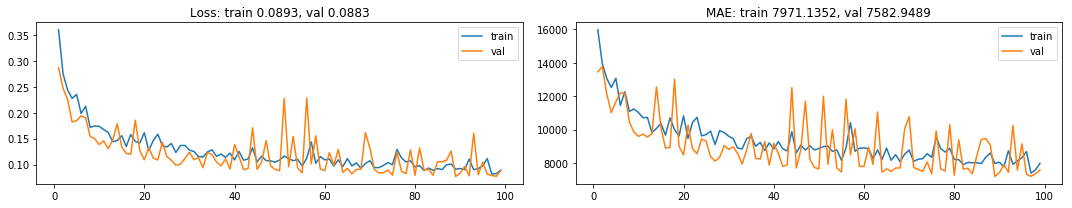

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:21:29<00:00, 48.60s/it]


Best epoch: 89
Best val MAE: 7186.8205


In [41]:
model = BestFullNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

PATH = 'models/BestFullNetworkV2.pt'
set_random_seeds(device=device)
train(model, opt, PATH=PATH, epochs_n=100, batch_size=32, max_batches=100)

### A short report

Please tell us what you did and how did it work.

In this task DNN model was implemented which is able to predict salary of an employee based on her title, description and categorical features. The most interesting part of the model architecture is encoding of title and description. Not only I tuned various hyperparameters and chose the best activation functions, but also I implemented the following:

* A) added dropout, batchnorm, created parallel convolutional blocks capturing features with filters of different sizes

* B) instead of single GlobalMaxPooling, I implemented and used also GlobalAvgPooling, SoftmaxPooling and AttentivePooling and concatenated all of them before linear extractor

* C) used pretrained word2vec embeddings of size 300 and trained them too

* D) along with poolings, I also concatenated output vectors of trained bidirectional LSTM

* E) saved the model state not after the last epoch, but after the one which shown the best MAE on validation

Also an important thing to notice is that I trained less parameters (in CNN and LSTM parts especially) for title encoder than for description encoder because I assumed that title contains less words than descriptions, hence less patterns in substrings, therefore the same number of parameters seems like an overkill and may perform worse.

The described tricks helped to achieve better validation MAE than the proposed baseline model: 7186.8205 vs 9707.3512 for the same optimizer parameters.